## Imports

In [1]:
import os

# Set environment variables
os.environ["HF_HOME"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["HF_DATASETS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["TRANSFORMERS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"

# Verify the variables (optional)
print("HF_HOME:", os.environ.get("HF_HOME"))
print("HF_DATASETS_CACHE:", os.environ.get("HF_DATASETS_CACHE"))
print("TRANSFORMERS_CACHE:", os.environ.get("TRANSFORMERS_CACHE"))

HF_HOME: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
HF_DATASETS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
TRANSFORMERS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache


In [2]:
from transformers import SamModel, SamProcessor
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import torch
from sklearn.manifold import MDS
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import random

/home/hice1/kpereira6/.conda/envs/cAI8803-gpu/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Load Model

#### CLIP

In [3]:
# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

### Load Data

In [4]:
folders = os.listdir('./numerosity_project - All Stimuli')

In [5]:
folders

['Natural images plain_bg',
 'Equal area triangles',
 'Natural images plain_bg_blurred',
 'Natural images dinner',
 'Random shape random area',
 '.DS_Store',
 'Natural images',
 'Equal circumference circles',
 'Equal area squares',
 'Stimuli generation guide.docx',
 'Equal area circles',
 'Natural images dinner_blurred']

### Utils

In [6]:
def get_a_random_pic(folder_name,numerosity):
    #randomly choose an image of particular numerosity from any area/circumference for a class
    candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}')
    folder_id = np.random.choice(candidates)
    folder_path = f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}/{folder_id}/{numerosity}'
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}/{folder_id}/{numerosity}/'+ pic


In [7]:
def distance_effect(dist_matrix):
    print("\n\nDistance Effect")

    # 1: Distance Effect
    diff = defaultdict(list)

    # Get diff
    for i in range(0, 9):
        for j in range(i+1, 9):
            key = abs(i-j)
            diff[key].append(1 - dist_matrix[i][j])

    # Average
    for keys in diff:
        diff[keys] = np.mean(diff[keys])

    X = np.array([i for i in range(1, 9)])
    Y = np.array([diff[i] for i in range(1, 9)])

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.figure(figsize=(10, 6))
    plt.xlabel("Numerical Difference between two numerosties |n1-n2|")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    # Fit a line
    params = linregress(X, Y)
    slope, intercept = params.slope, params.intercept
    y_pred = slope * X + intercept

    fig, ax = plt.subplots()
    ax.scatter(X, Y, label='Data Points', color='blue')
    ax.plot(X, y_pred, label='Linear Fit', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    # Print fitted parameters
    print("Fitted parameters:")
    print('Slope', slope)
    print('Intercept', intercept)

In [8]:
def size_effect(dist_matrix):
    print("\n\nSize Effect")

    # 2: Size Effect
    X = []
    Y = []

    size = defaultdict(list)
    for i in range(1, 10):
        for j in range(i+1, 10):
            key = (i+j) // 2
            size[key].append(1 - dist_matrix[i-1][j-1])

    # Average
    for keys in size:
        size[keys] = np.mean(size[keys])

    X = np.array(sorted(size.keys()))  # Sizes (average magnitude)
    Y = np.array([size[key] for key in X])

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.figure(figsize=(10, 6))
    plt.xlabel("Size (n1+n2)/2")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    params = linregress(X, Y)
    slope, intercept = params.slope, params.intercept
    y_pred = slope * X + intercept

    fig, ax = plt.subplots()
    ax.scatter(X, Y, label='Data Points', color='blue')
    ax.plot(X, y_pred, label='Linear Fit', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    print("Fitted parameters:")
    print('Slope', slope)
    print('Intercept', intercept)


In [9]:
from scipy.optimize import curve_fit

def ratio_effect(dist_matrix):
    print("\n\nRatio Effect")

    # 3: Ratio Effect
    X = []
    Y = []
    for i in range(0, 9):
        for j in range(i+1, 9):
            X.append(max(i+1, j+1)/ min(i+1, j+1))
            Y.append(1 - dist_matrix[i][j])

    X = np.array(X)
    Y = np.array(Y)

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.xlabel("Max/Min")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    # Fit the curve (Exponential decay)
    params, covariance = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, X, Y, maxfev=1000000)

    # Extract fitted parameters
    a_fit, b_fit, c_fit = params
    y_pred = a_fit * np.exp(np.array(X)* - b_fit) + c_fit

    # Calculate R^2
    y_mean = np.mean(Y)
    ss_res = np.sum((Y - y_pred)**2)
    ss_tot = np.sum((Y - y_mean)**2)
    r_squared = 1 - (ss_res / ss_tot)

    print("R-squared value =", r_squared)

    # Plot the data points
    fig, ax = plt.subplots()
    plt.scatter(X, Y, label='Data Points', color='blue')

    # Plot the fitted curve
    x_fit = np.linspace(min(X), max(X), 100)
    y_fit = a_fit * np.exp(np.array(x_fit)* - b_fit) + c_fit
    plt.plot(x_fit, y_fit, label='Fitted Curve', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()


In [10]:
path = f"./numerosity_project - All Stimuli/"

#### Experiments

### MDS

In [11]:
def handle_mds(M, category, n_comp = 1):
    plt.figure(figsize=(8, 6))
    if n_comp == 1:
        mds = MDS(n_components=1, dissimilarity="precomputed", random_state = 42)
        embedding = mds.fit_transform(M)
        stress = mds.stress_

        plt.scatter(embedding[:, 0], np.zeros_like(embedding[:, 0]), alpha=0.7, color='blue')
        for i in range(9):
            plt.text(embedding[i, 0], 0, f"{i+1}", fontsize=15, ha='right', va='center')
    elif n_comp == 2:
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state = 42)
        embedding = mds.fit_transform(M)
        stress = mds.stress_

        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.7, color='blue')
        for i in range(9):
            plt.text(embedding[i, 0], embedding[i, 1], f"{i+1}", fontsize=15, ha='right', va='center')

    plt.title(f"MDS Visualization for {category}:\nStress: {stress}")
    plt.xlabel("1D Embedding")
    plt.yticks([])
    plt.grid(True, axis='x')
    plt.show()

### Experiment 1

In [85]:
def get_a_random_pic_for_exp1(folder_id,numerosity):
    #folder_id -> area
    #randomly choose an image of particular numerosity from any area class
    #circle select two from same area
    # candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/Equal area circles')

    folder_path = f'./numerosity_project - All Stimuli/Equal area circles/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [86]:
get_a_random_pic_for_exp1('A1',1)

'./numerosity_project - All Stimuli/Equal area circles/A1/1/1_16.png'

In [87]:
def createNumerosityDistanceMatrix_Exp1(model, processor, device="cuda",M=20,Area='A2'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp1(Area,i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_features(img_inputs["pixel_values"])[0]
            temp_vectors.append(img_embeddings.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [88]:
dist_matrix = createNumerosityDistanceMatrix_Exp1(model,processor)

(512,)




Distance Effect
Pearsons correlation: -0.9436723031638852
Fitted parameters:
Slope -0.013840117934001544
Intercept 1.015740758454313


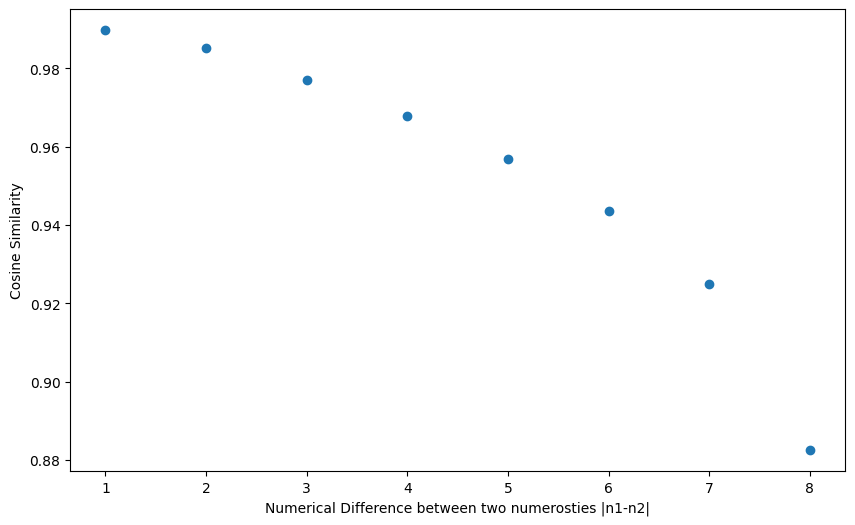

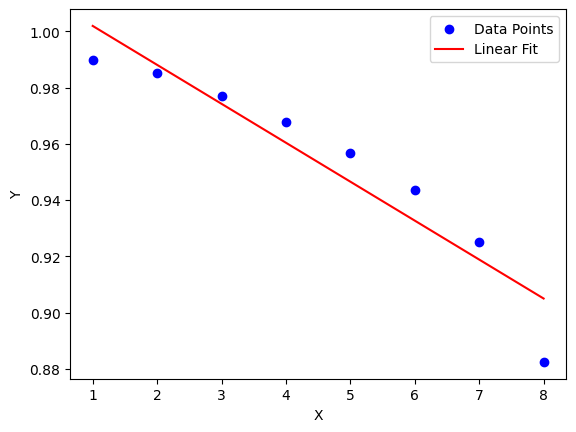

In [89]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.9763025008523489
Fitted parameters:
Slope 0.008868595689129668
Intercept 0.9286667047005122


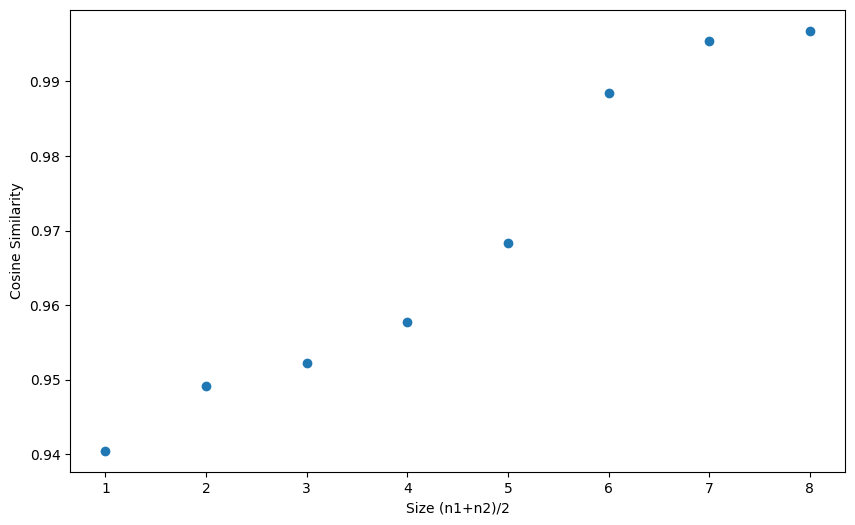

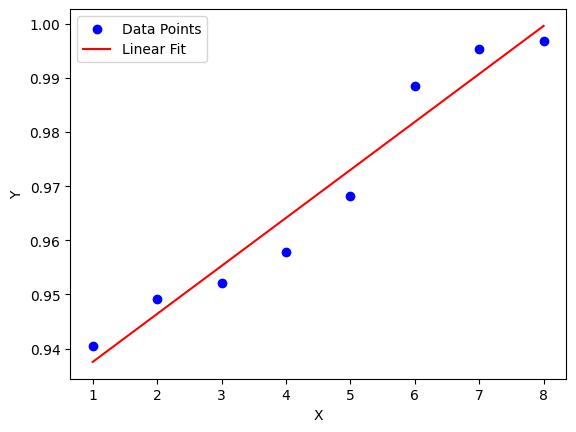

In [90]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.930886330103995
R-squared value = 0.8802704922985725


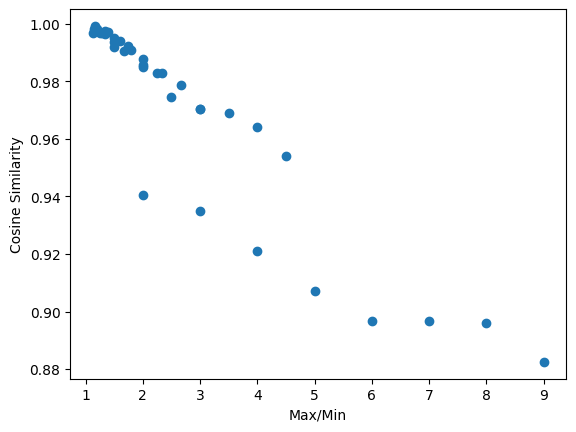

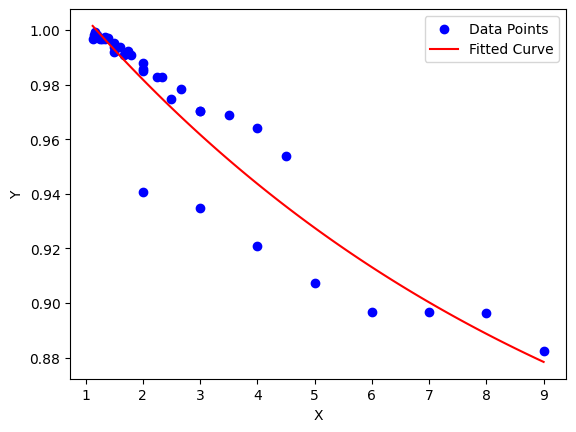

In [91]:
ratio_effect(dist_matrix)

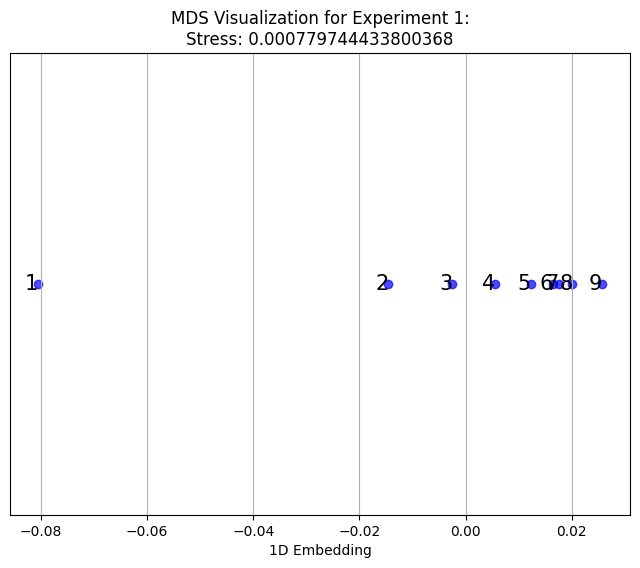

In [92]:
handle_mds(dist_matrix, "Experiment 1", n_comp = 1)

### Experiment 2

In [93]:
def get_a_random_pic_for_exp2(folder_id,numerosity):
    #folder_id -> area
    #randomly choose an image of particular numerosity from any area class
    #circle select two from same area
    # candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/Equal area circles')

    folder_path = f'./numerosity_project - All Stimuli/Equal circumference circles/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [94]:
def createNumerosityDistanceMatrix_Exp2(model, processor, device="cuda",M=20,C='C1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp2(C,i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_features(img_inputs["pixel_values"])[0]
            temp_vectors.append(img_embeddings.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [95]:
dist_matrix = createNumerosityDistanceMatrix_Exp2(model,processor)

(512,)




Distance Effect
Pearsons correlation: -0.966721329209423
Fitted parameters:
Slope -0.010319158262541504
Intercept 1.005154975012046


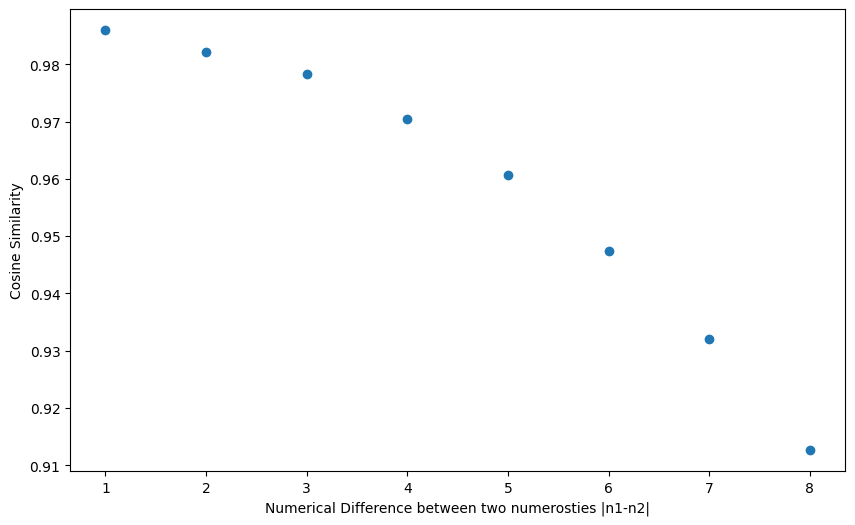

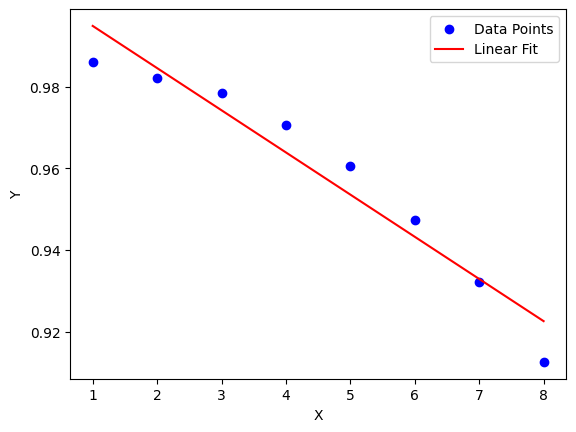

In [96]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.9516502430989311
Fitted parameters:
Slope 0.011701149056726846
Intercept 0.9133149273389456


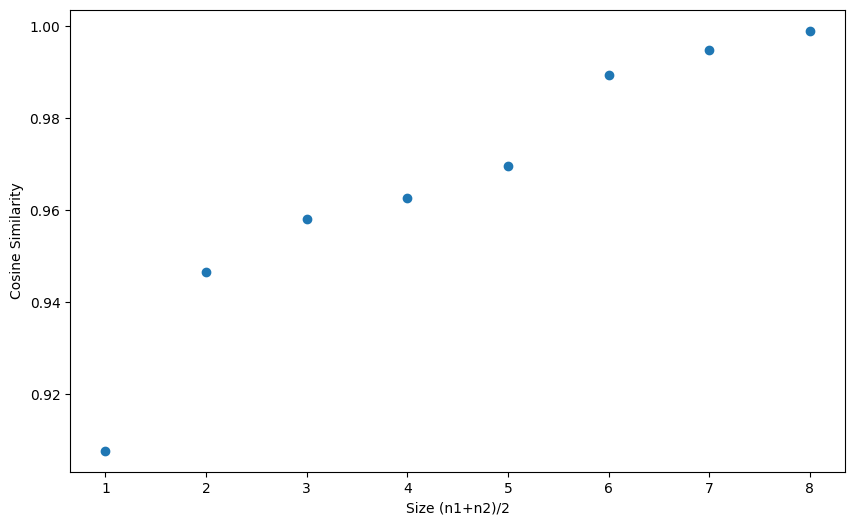

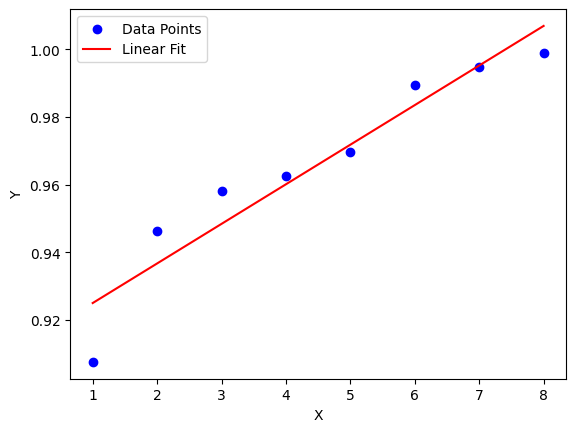

In [97]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.8317802307935075
R-squared value = 0.7558113183176853


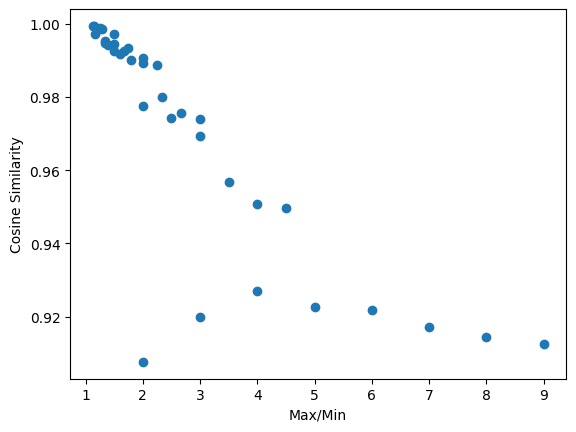

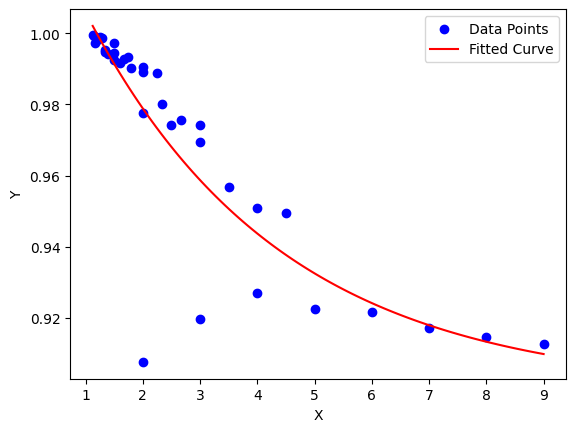

In [98]:
ratio_effect(dist_matrix)

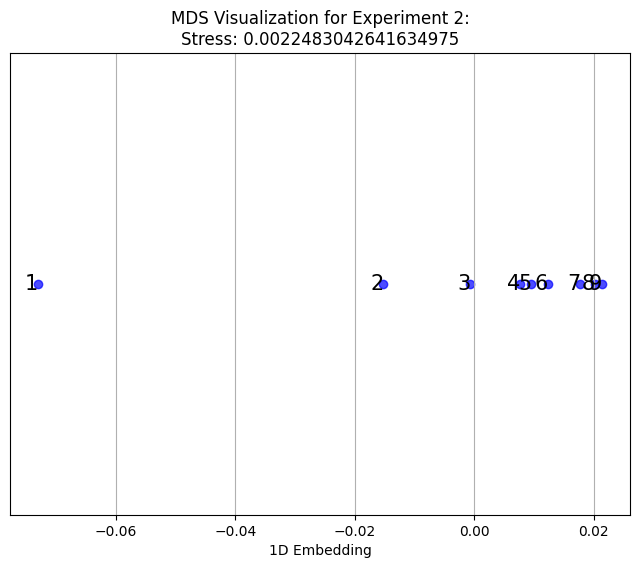

In [99]:
handle_mds(dist_matrix, "Experiment 2", n_comp = 1)

### Experiment 3

In [100]:
os.listdir('./numerosity_project - All Stimuli')

['Natural images plain_bg',
 'Equal area triangles',
 'Natural images plain_bg_blurred',
 'Natural images dinner',
 'Random shape random area',
 '.DS_Store',
 'Natural images',
 'Equal circumference circles',
 'Equal area squares',
 'Stimuli generation guide.docx',
 'Equal area circles',
 'Natural images dinner_blurred']

In [101]:
shapes = ['Equal area squares','Equal area circles','Equal area triangles']

In [102]:
def get_a_random_pic_for_exp3(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/{shape}/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [103]:
def createNumerosityDistanceMatrix_Exp3(model, processor, device="cuda",M=20,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    shape_dict = {i: random.choice(shapes) for i in range(1, 10)}

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp3(A,i,shape_dict[i])
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_features(img_inputs["pixel_values"])[0]
            temp_vectors.append(img_embeddings.cpu().numpy())  # Move embeddings to CPU to avoid memory issues
# Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [104]:
dist_matrix = createNumerosityDistanceMatrix_Exp3(model,processor)

(512,)




Distance Effect
Pearsons correlation: -0.9742272030641984
Fitted parameters:
Slope -0.007672910004550095
Intercept 0.9991713600347236


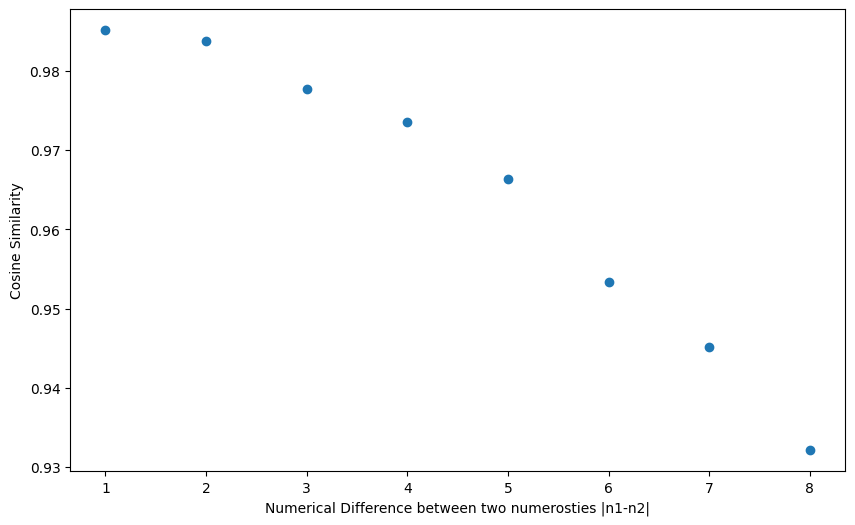

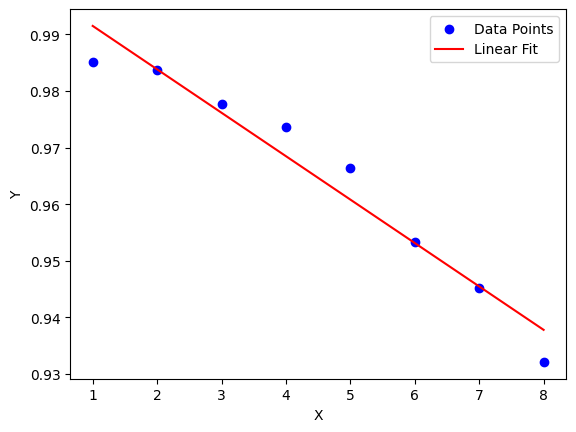

In [105]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.9785862508524872
Fitted parameters:
Slope 0.0061162961617348644
Intercept 0.9458562467069853


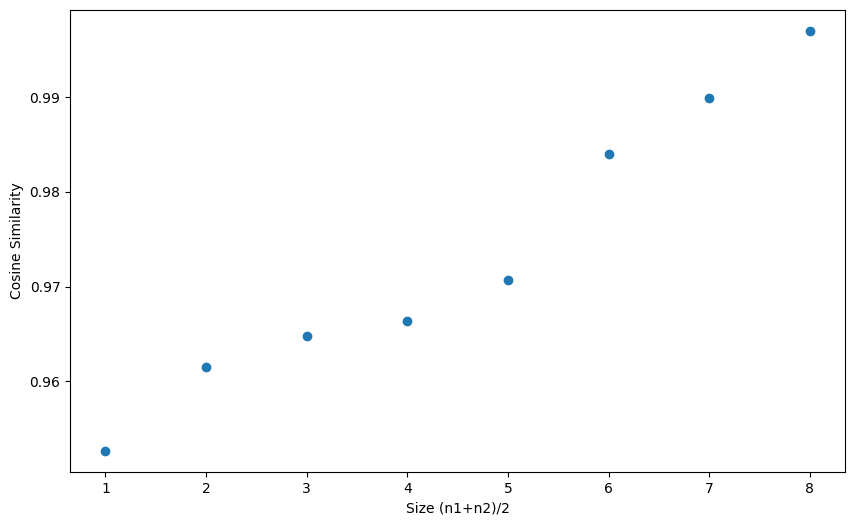

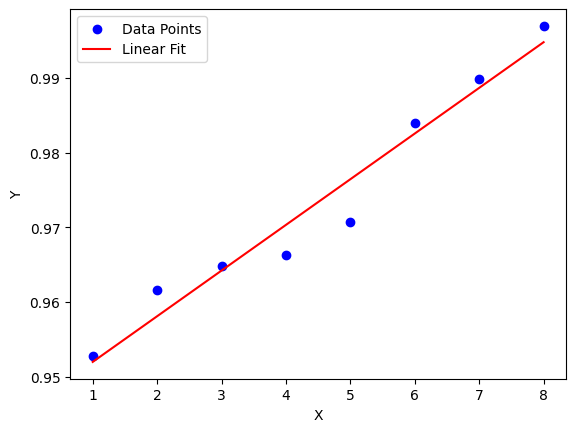

In [106]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.8873559551893576
R-squared value = 0.8566502925634787


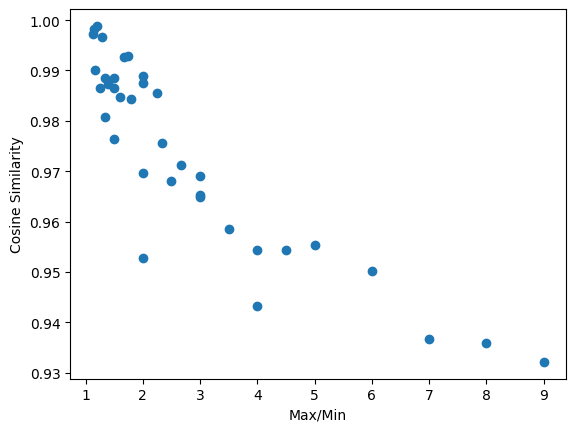

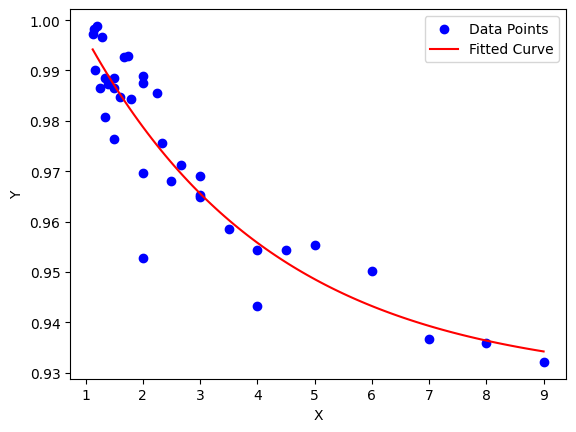

In [107]:
ratio_effect(dist_matrix)

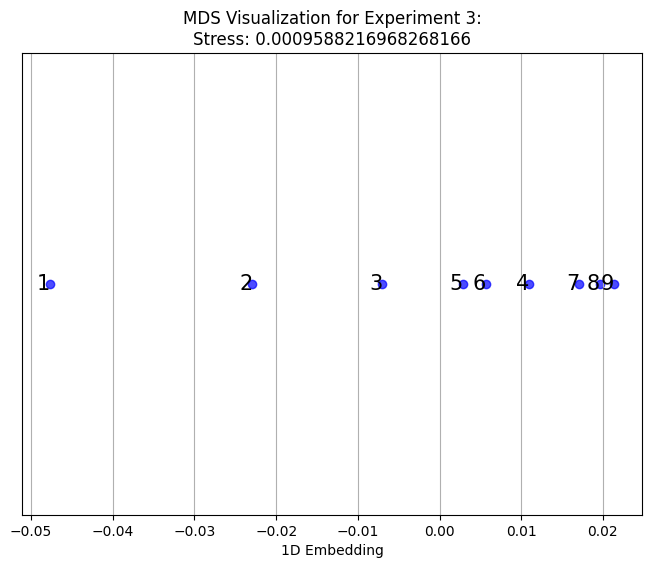

In [108]:
handle_mds(dist_matrix, "Experiment 3", n_comp = 1)

## Experiment 4


In [109]:
def get_a_random_pic_for_exp4(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/{shape}/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [110]:
def createNumerosityDistanceMatrix_Exp4(model, processor, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)
    shape_dict = {i: random.choice(shapes) for i in range(1, 10)}
    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess

            A = random.choice(['A1','A2','A3','A4','A5'])
            img_path = get_a_random_pic_for_exp4(A,i,shape_dict[i])
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_features(img_inputs["pixel_values"])[0]
            temp_vectors.append(img_embeddings.cpu().numpy())  # Move embeddings to CPU to avoid memory issues
 # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [111]:
dist_matrix = createNumerosityDistanceMatrix_Exp4(model,processor)

(512,)




Distance Effect
Pearsons correlation: -0.9141688273535585
Fitted parameters:
Slope -0.009151871874928474
Intercept 0.9918058328330517


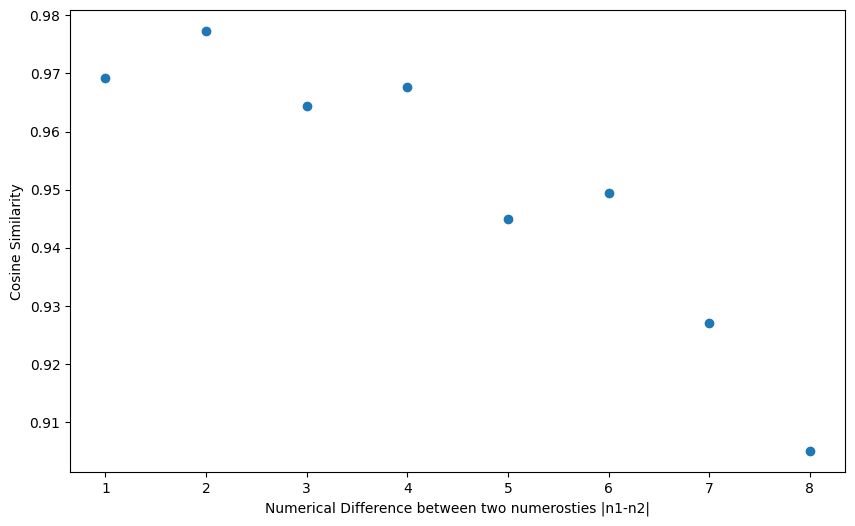

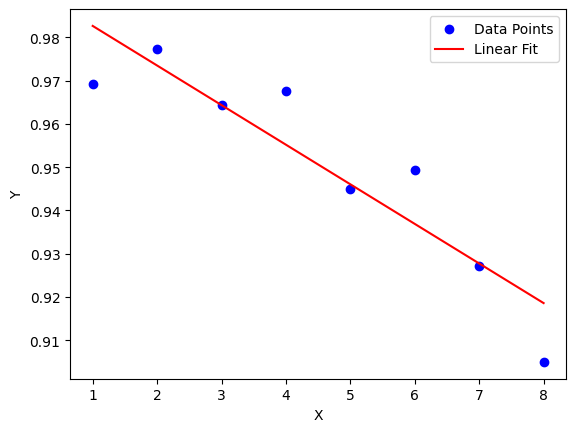

In [112]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.9678163387826136
Fitted parameters:
Slope 0.008515128816843305
Intercept 0.9215387153027415


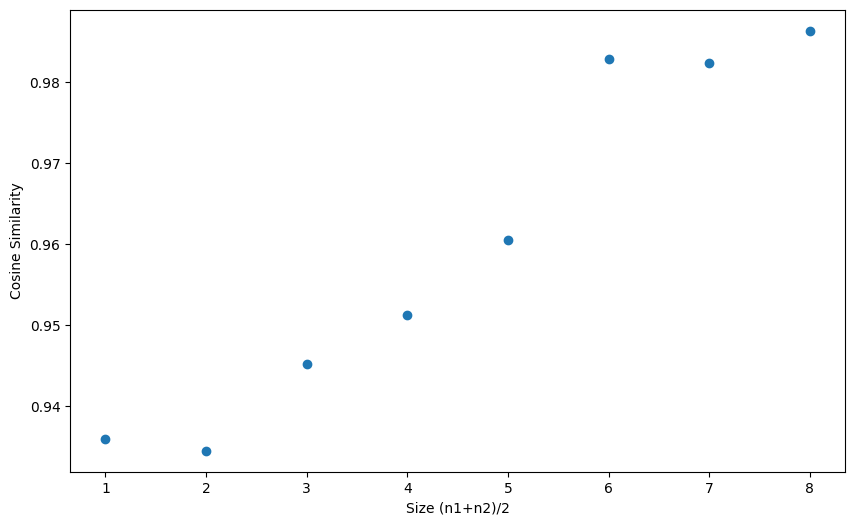

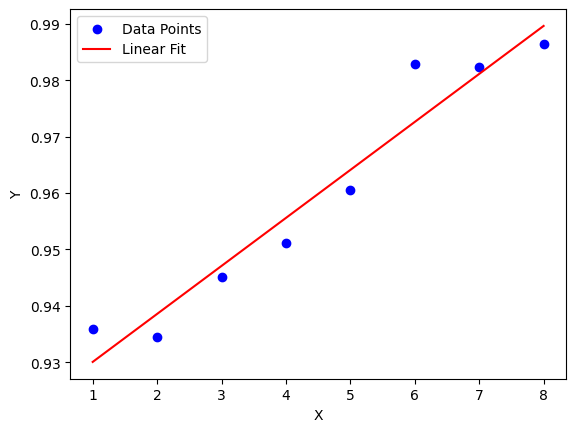

In [113]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.7996155288008229
R-squared value = 0.6571903805271984


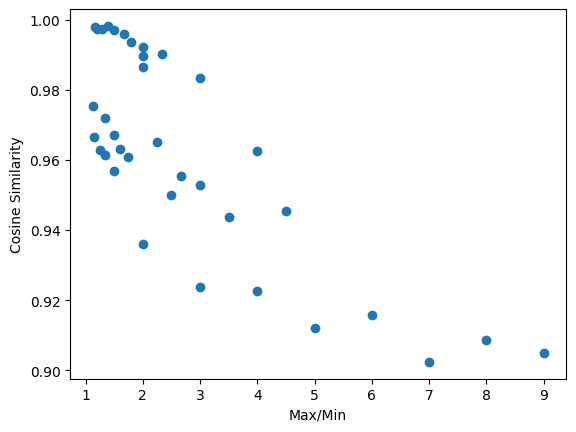

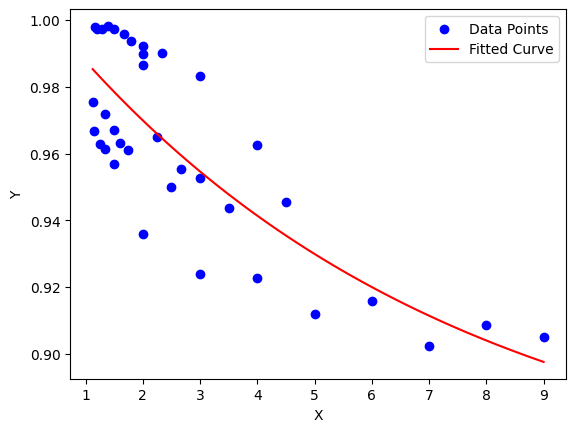

In [114]:
ratio_effect(dist_matrix)

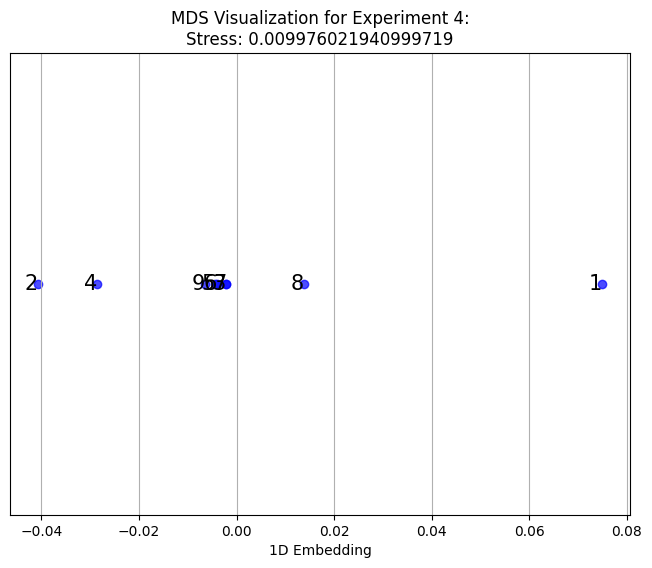

In [115]:
handle_mds(dist_matrix, "Experiment 4", n_comp = 1)

### Experiment 5

In [12]:
def get_a_random_pic_for_exp5(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Random shape random area/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [13]:
def createNumerosityDistanceMatrix_Exp5(model, processor, device="cuda",M=60,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            shape = random.choice(['Equal area squares','Equal area circles','Equal area triangles'])
            A = random.choice(['A1','A2','A3','A4','A5'])
            img_path = get_a_random_pic_for_exp5(A,i,shape)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_features(img_inputs["pixel_values"])[0]
            temp_vectors.append(img_embeddings.cpu().numpy())  # Move embeddings to CPU to avoid memory issues
# Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [14]:
dist_matrix = createNumerosityDistanceMatrix_Exp5(model,processor)

(512,)




Distance Effect
Pearsons correlation: -0.9674562623483703
Fitted parameters:
Slope -0.00974674962055521
Intercept 1.0097181512942526


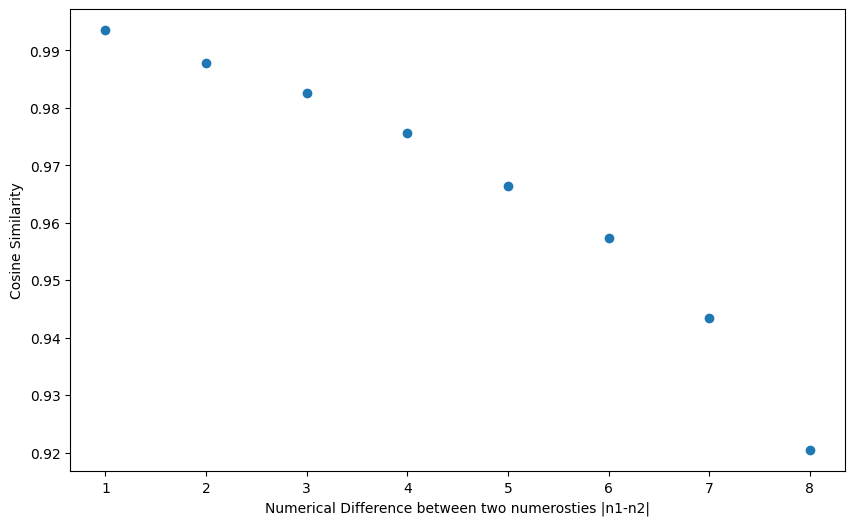

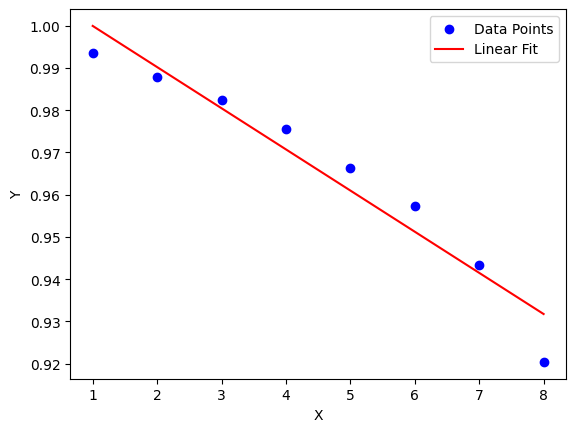

In [15]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.8942305165547292
Fitted parameters:
Slope 0.004901376481499529
Intercept 0.9562995128485621


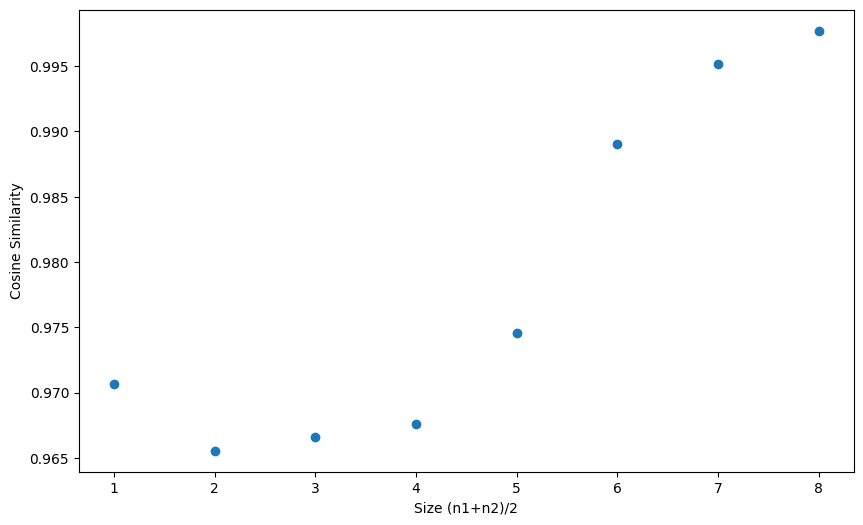

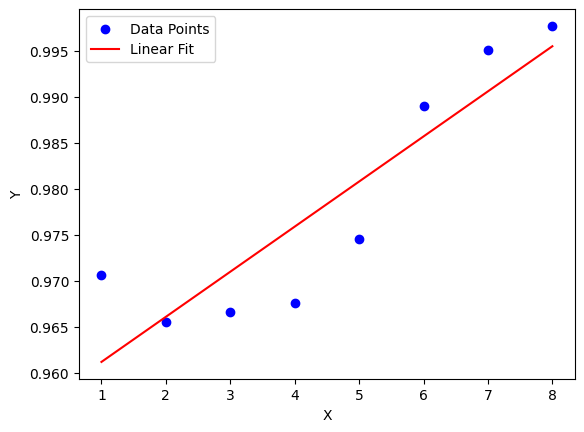

In [16]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.9625600596174553
R-squared value = 0.9450469114874965


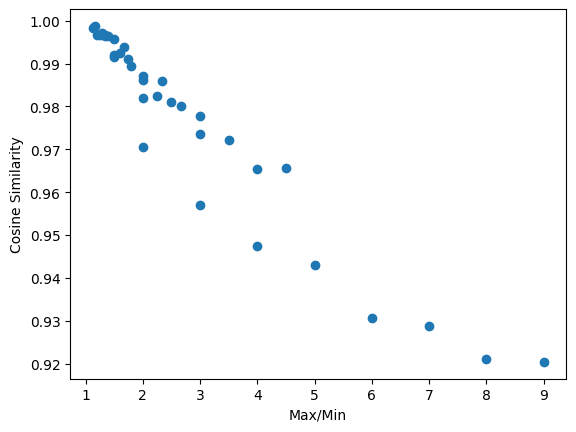

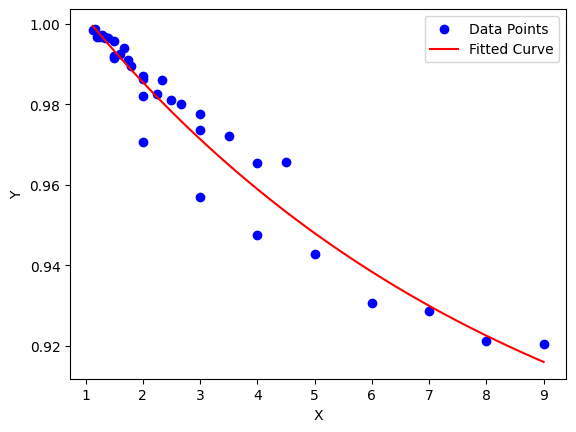

In [17]:
ratio_effect(dist_matrix)

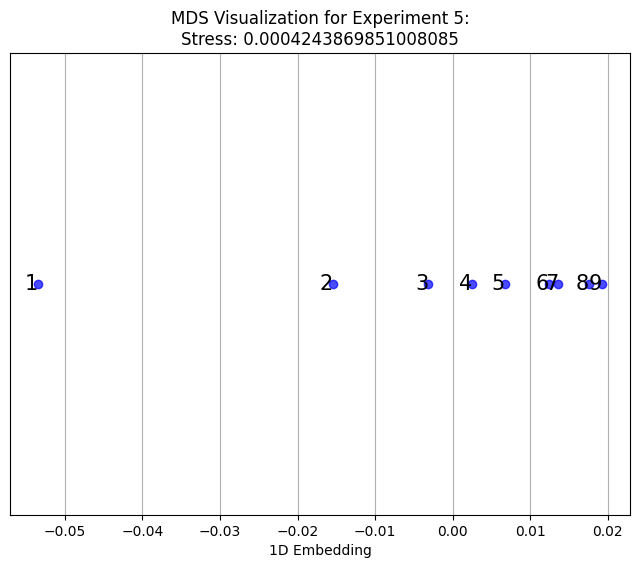

In [18]:
handle_mds(dist_matrix, "Experiment 5", n_comp = 1)

### Naturalistic Images (Exp6)

In [123]:
def get_a_random_pic_for_exp6(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [124]:
def createNumerosityDistanceMatrix_Exp6(model, processor, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp6(i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_features(img_inputs["pixel_values"])[0]
            temp_vectors.append(img_embeddings.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [125]:
dist_matrix = createNumerosityDistanceMatrix_Exp6(model,processor)

(512,)




Distance Effect
Pearsons correlation: -0.9556527969003101
Fitted parameters:
Slope -0.0073284709129203774
Intercept 0.9736578178649047


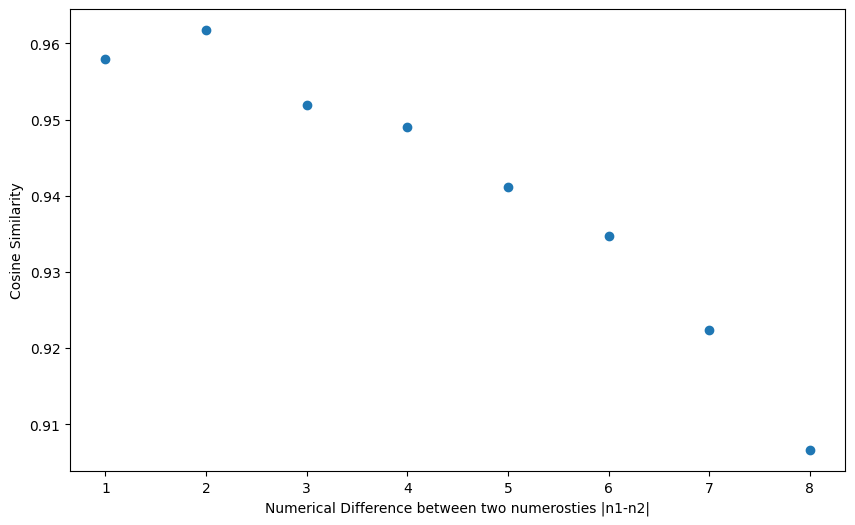

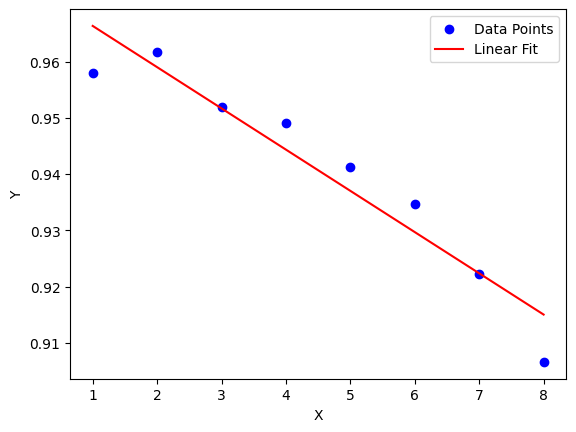

In [126]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.899576876314552
Fitted parameters:
Slope 0.005091113277844022
Intercept 0.926818428507873


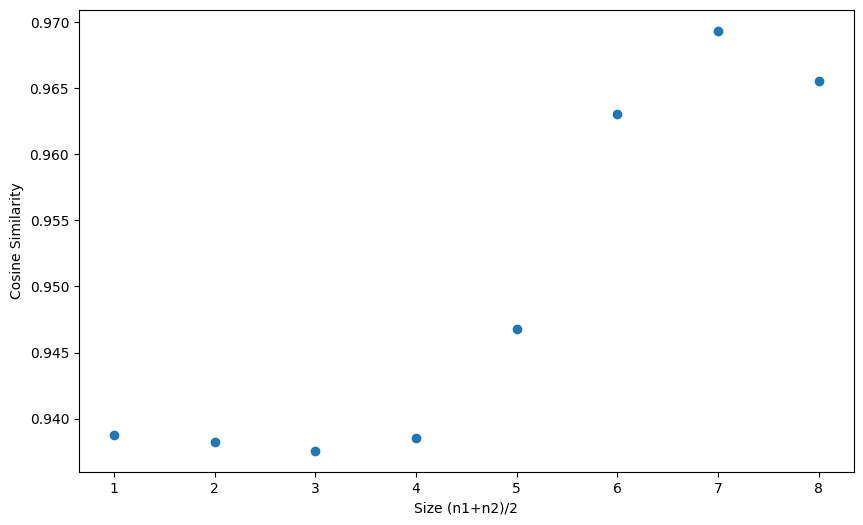

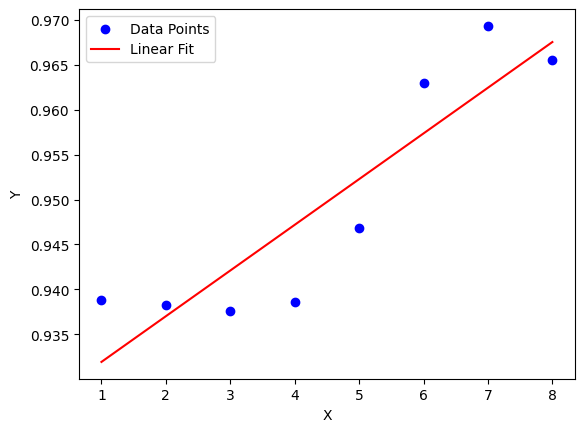

In [127]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.8289085892052406
R-squared value = 0.7254936551835995


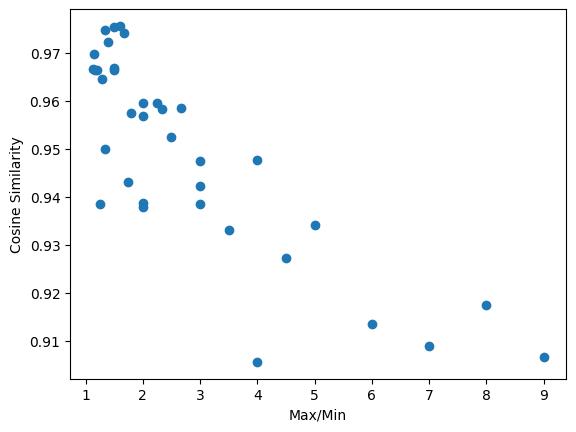

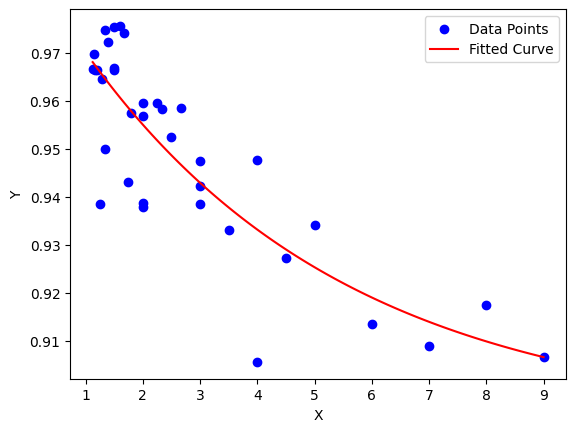

In [128]:
ratio_effect(dist_matrix)

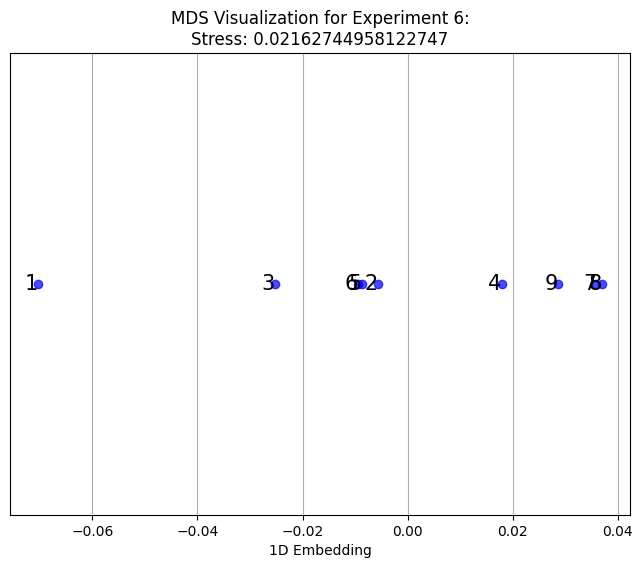

In [129]:
handle_mds(dist_matrix, "Experiment 6", n_comp = 1)

#### Experiments with added background



In [130]:
### Natural images bg plain

def get_a_random_pic_for_exp7(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images plain_bg/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic

def get_a_random_pic_for_exp8(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images plain_bg_blurred/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


def get_a_random_pic_for_exp9(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images dinner/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


def get_a_random_pic_for_exp10(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images dinner_blurred/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic



In [131]:
def createNumerosityDistanceMatrix_Exp(model, processor,get_image, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_image(i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_features(img_inputs["pixel_values"])[0]
            temp_vectors.append(img_embeddings.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [132]:

exp7 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp7)
exp8 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp8)
exp9 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp9)
exp10 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp10)

(512,)
(512,)
(512,)
(512,)


#### Experiment 7 results



Distance Effect
Pearsons correlation: -0.93462504641512
Fitted parameters:
Slope -0.007513492247786655
Intercept 0.9847853761293045


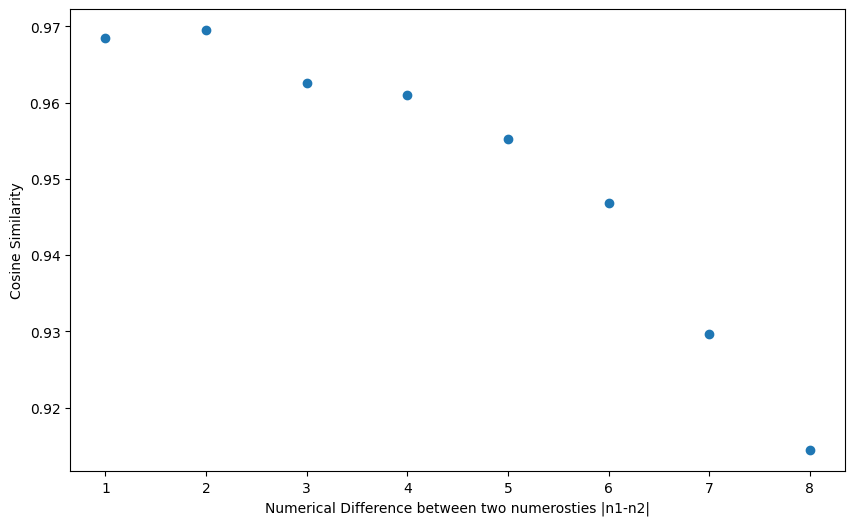

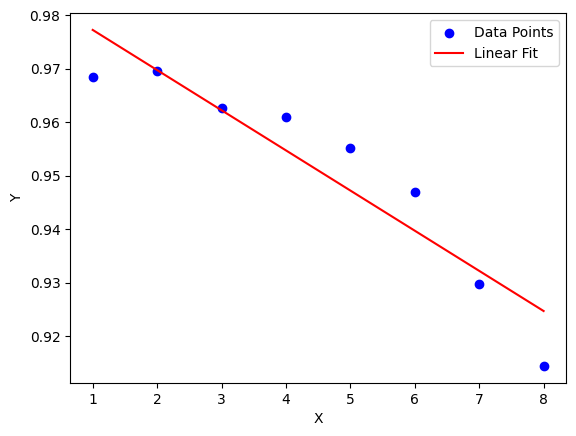

In [133]:
distance_effect(exp7)



Size Effect
Pearsons correlation: 0.8441379349000999
Fitted parameters:
Slope 0.003429669437427371
Intercept 0.9447525270638012


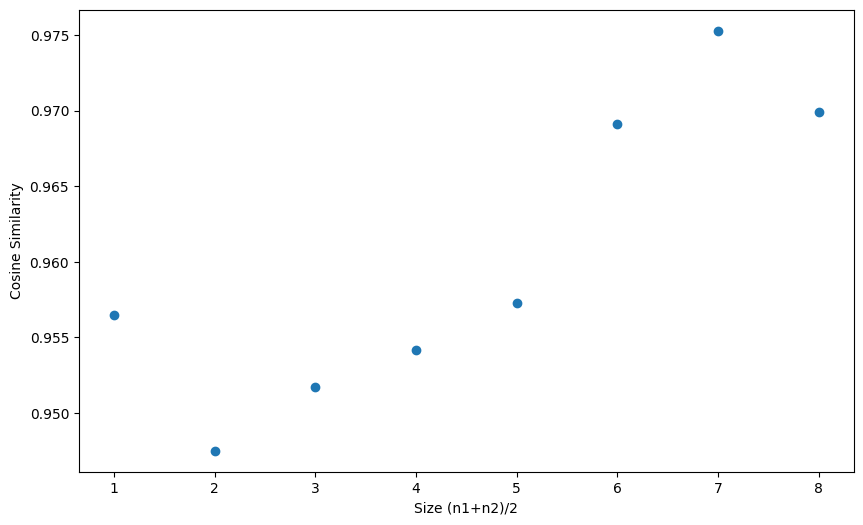

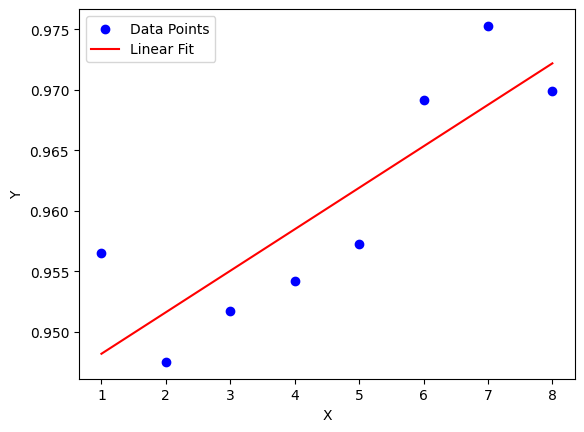

In [134]:
size_effect(exp7)



Ratio Effect
Pearsons correlation: -0.8907878791601894
R-squared value = 0.8216607298366797


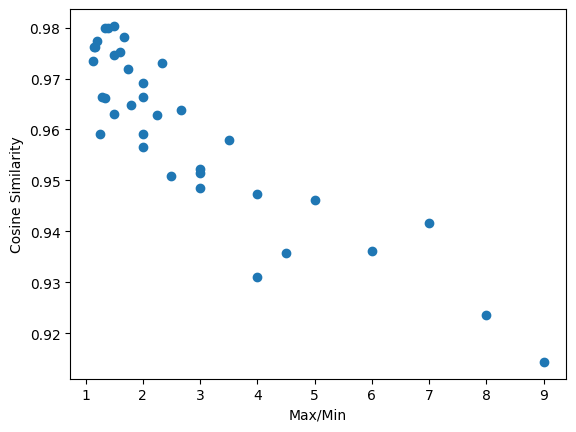

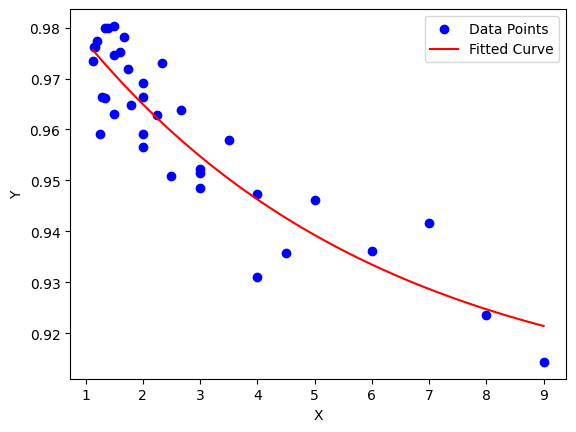

In [135]:
ratio_effect(exp7)

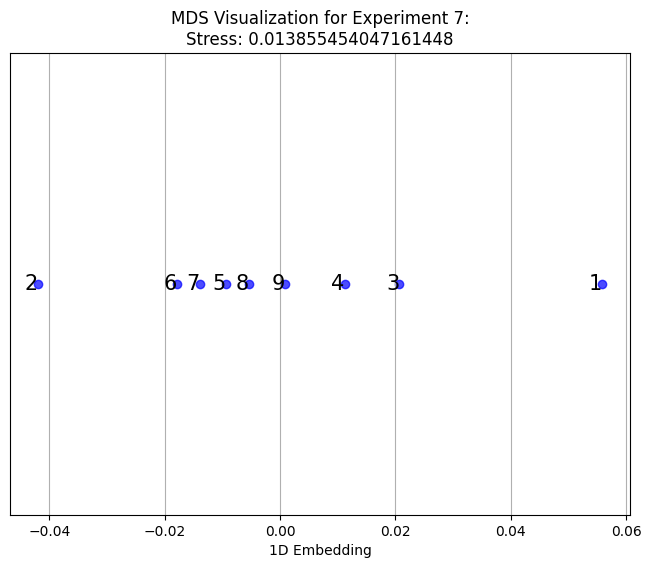

In [136]:
handle_mds(exp7, "Experiment 7", n_comp = 1)

### Experiment 8 results



Distance Effect
Pearsons correlation: -0.9402324331869993
Fitted parameters:
Slope -0.005796772946103093
Intercept 0.9715182821260018


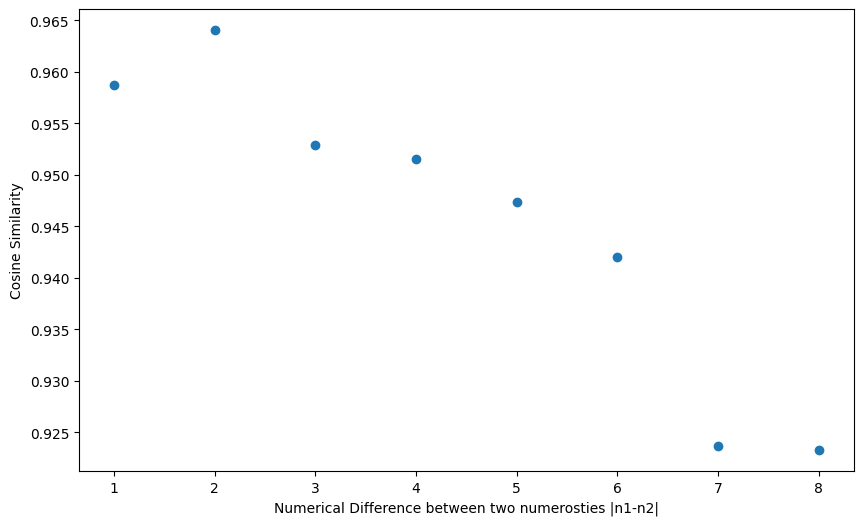

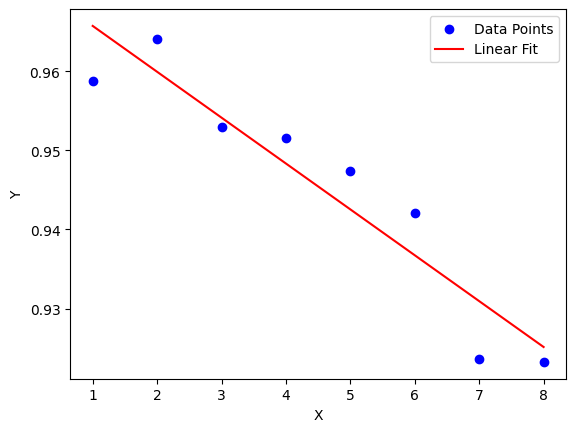

In [137]:
distance_effect(exp8)



Size Effect
Pearsons correlation: 0.9032986184104875
Fitted parameters:
Slope 0.004631354816072115
Intercept 0.9316892852537891


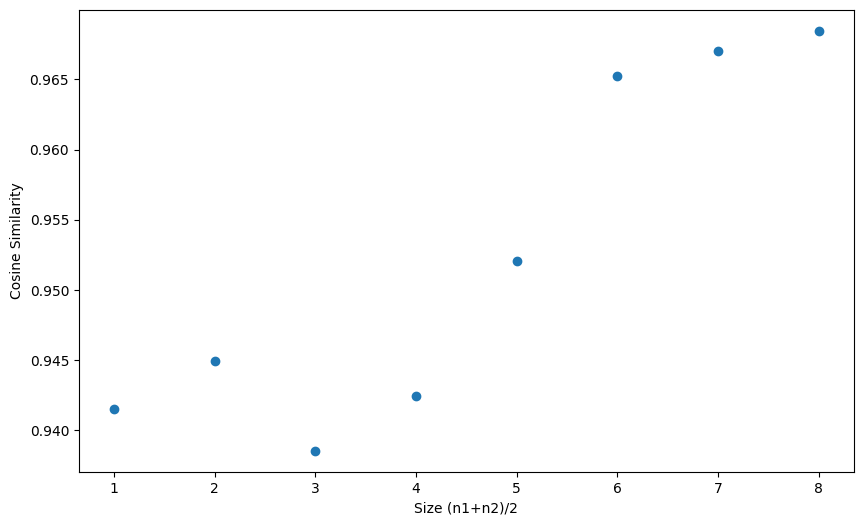

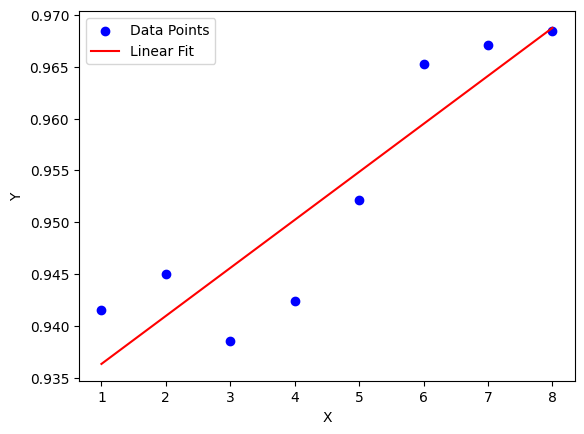

In [138]:
size_effect(exp8)



Ratio Effect
Pearsons correlation: -0.8012353750854591
R-squared value = 0.6754020518999557


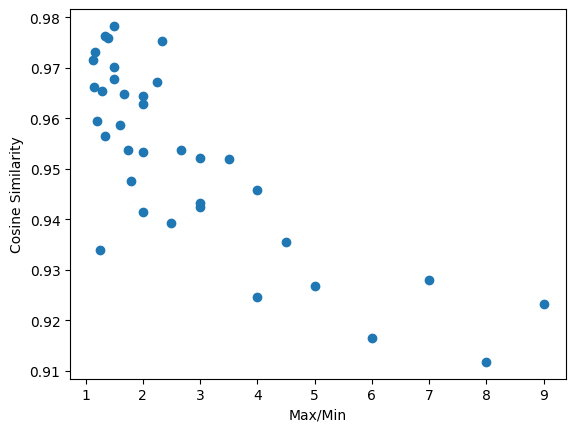

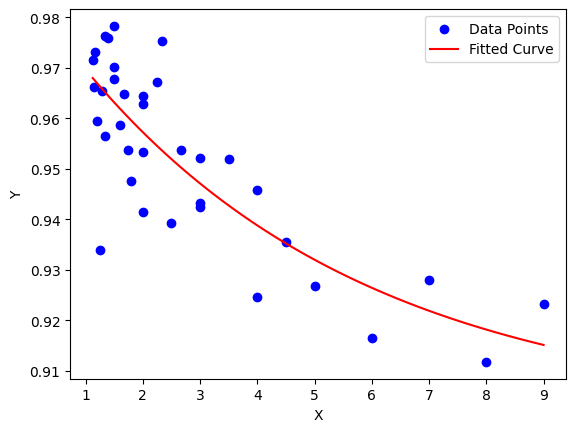

In [139]:
ratio_effect(exp8)

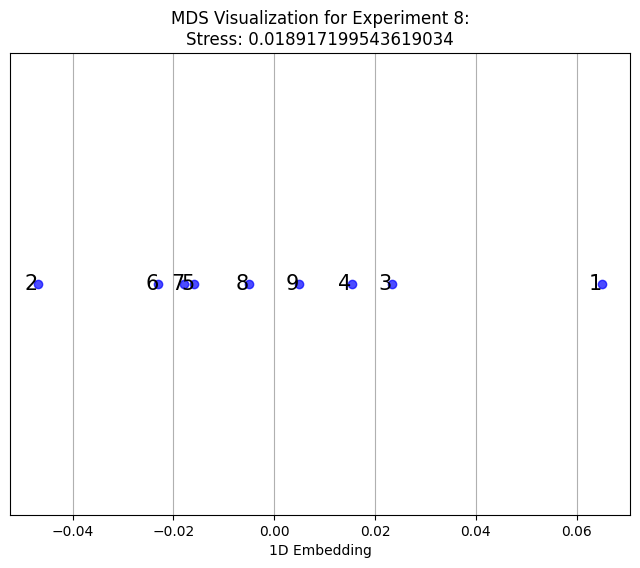

In [140]:
handle_mds(exp8, "Experiment 8", n_comp = 1)

#### Experiment 9



Distance Effect
Pearsons correlation: -0.8635183155839128
Fitted parameters:
Slope -0.011324097327634588
Intercept 0.9958173106519543


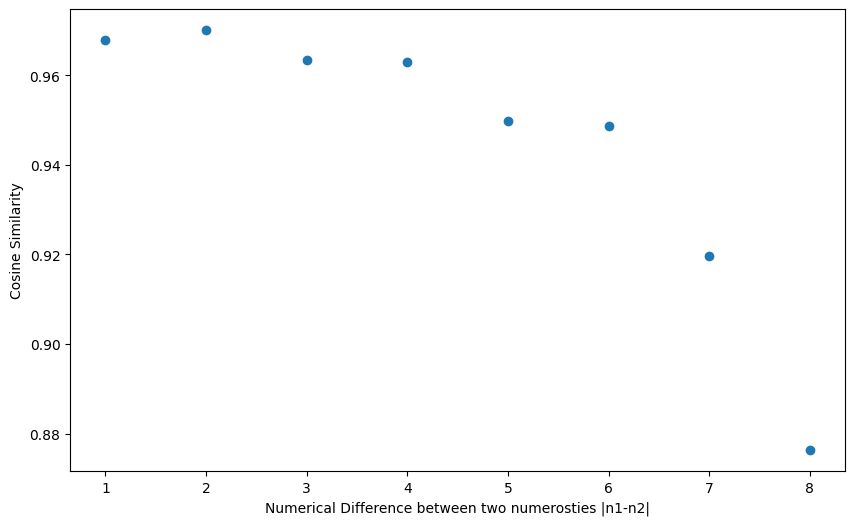

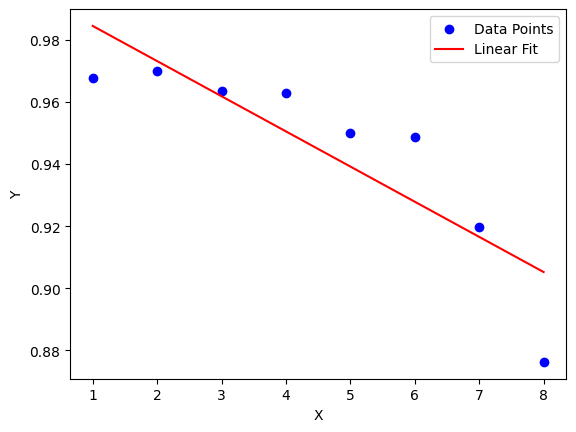

In [141]:
distance_effect(exp9)



Size Effect
Pearsons correlation: 0.6577843370320499
Fitted parameters:
Slope 0.0020906708627736483
Intercept 0.9488273136469783


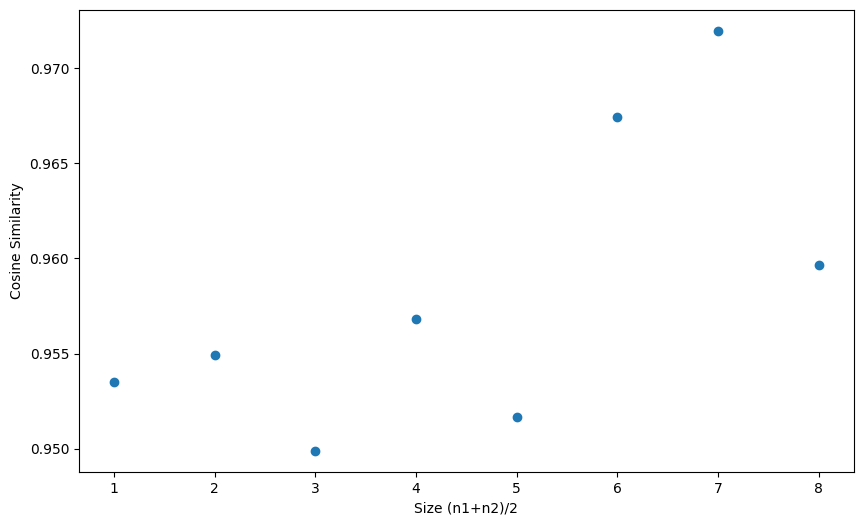

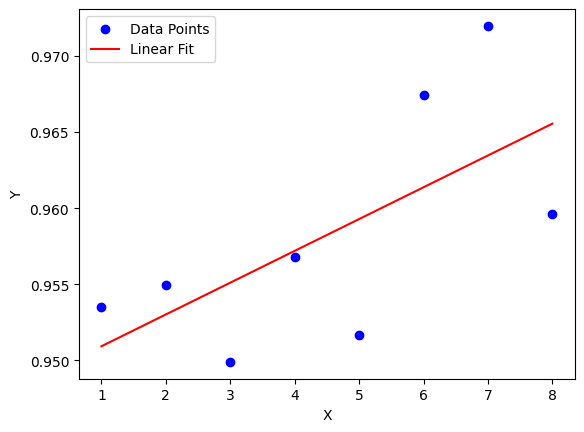

In [142]:
size_effect(exp9)



Ratio Effect
Pearsons correlation: -0.8790678245496901
R-squared value = 0.7727524321935927


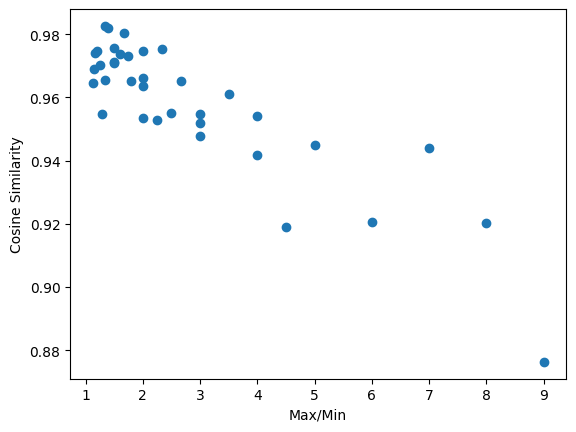

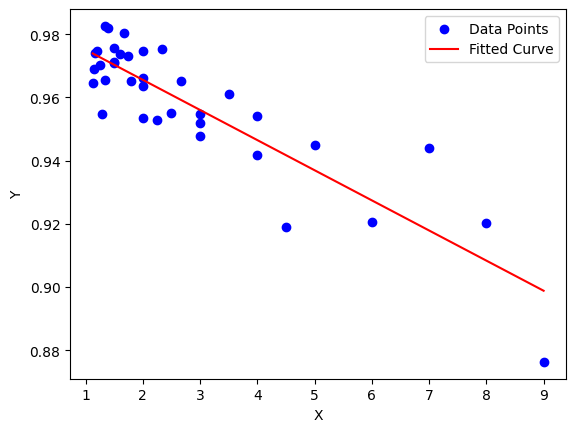

In [143]:
ratio_effect(exp9)

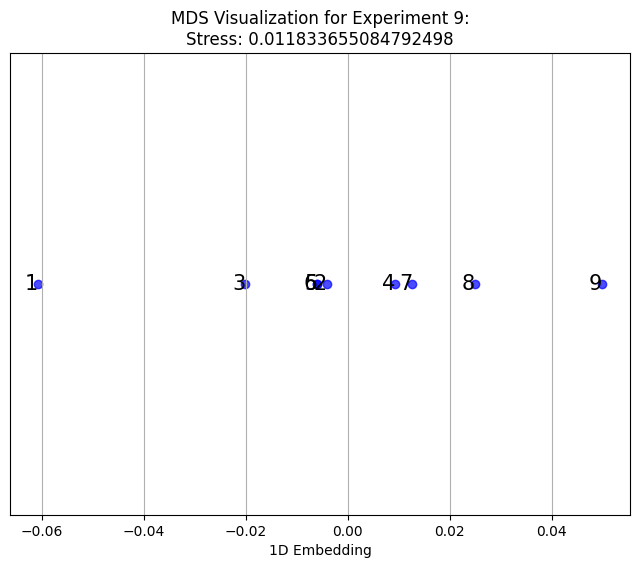

In [144]:
handle_mds(exp9, "Experiment 9", n_comp = 1)

### Experiment 10



Distance Effect
Pearsons correlation: -0.9067568449297041
Fitted parameters:
Slope -0.009028242954186033
Intercept 0.9815682832683835


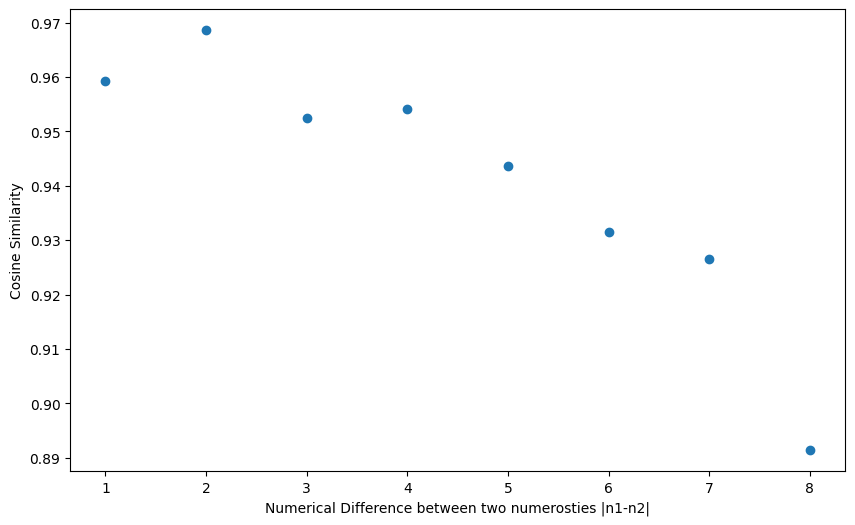

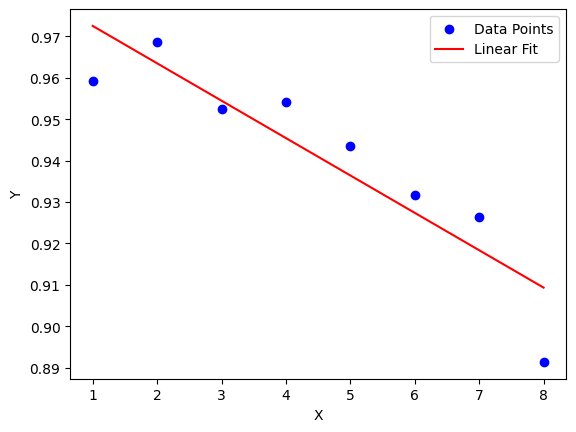

In [145]:
distance_effect(exp10)



Size Effect
Pearsons correlation: 0.9641977126365424
Fitted parameters:
Slope 0.008414580421247722
Intercept 0.9111520052463019


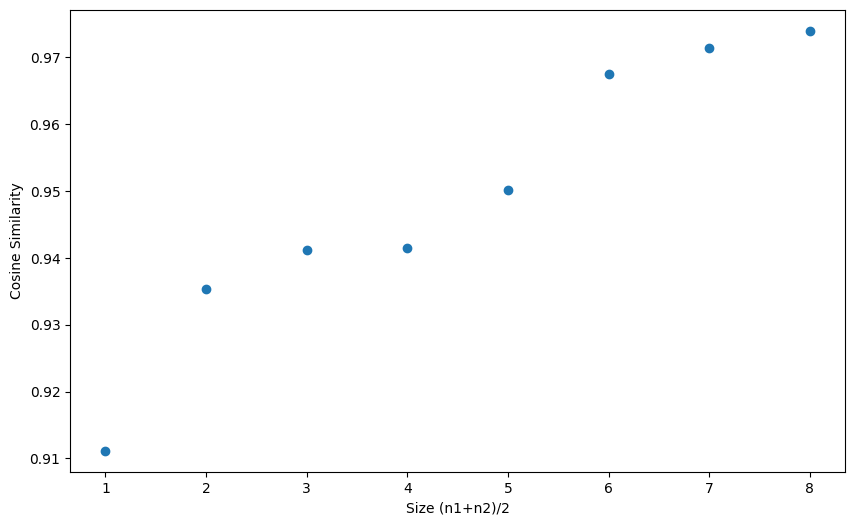

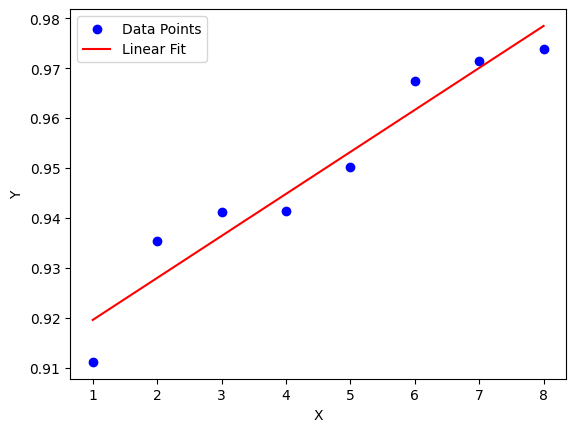

In [146]:
size_effect(exp10)



Ratio Effect
Pearsons correlation: -0.8617586828433474
R-squared value = 0.7602009017549806


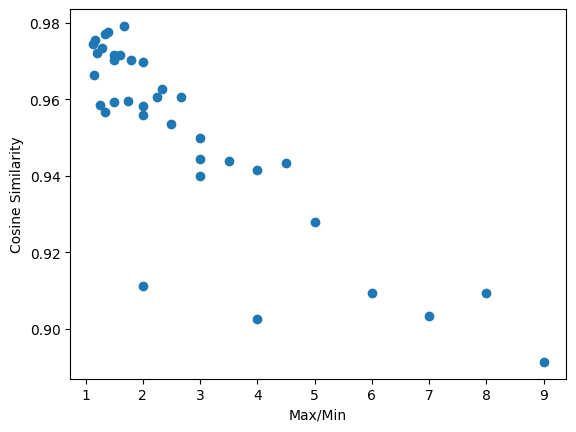

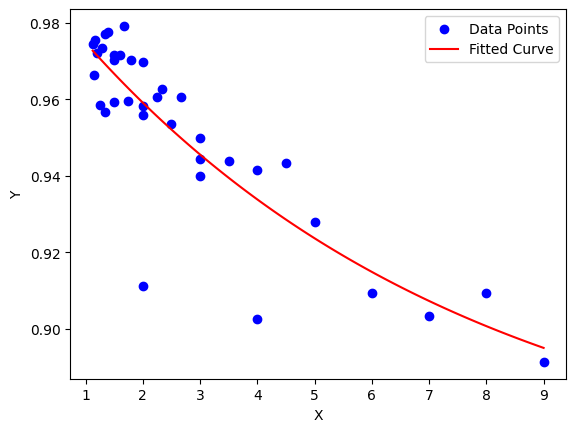

In [147]:
ratio_effect(exp10)

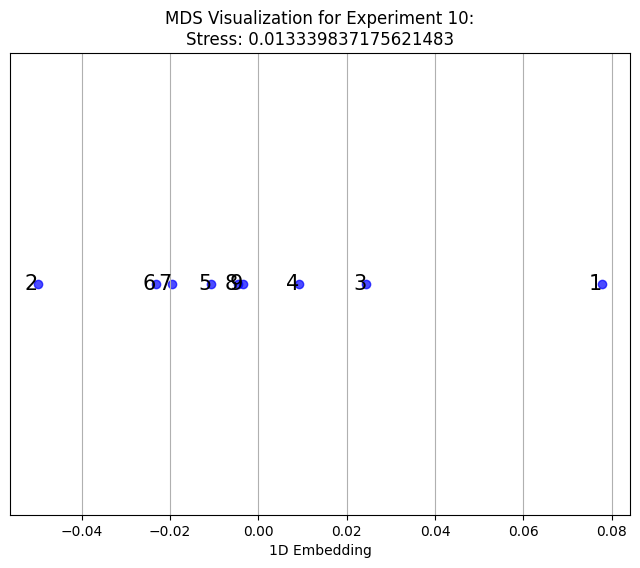

In [148]:
handle_mds(exp10, "Experiment 10", n_comp = 1)